In [ ]:
!wget https://storage.googleapis.com/comptech2021-ocr/comptech_segmentation_handwritten.zip
!unzip comptech_segmentation_handwritten.zip

In [ ]:
import pandas as pd
import glob
import os
from PIL import Image
import numpy as np
import json
from skimage import draw
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations import Compose, Normalize, Rotate, Resize, ToGray
import albumentations as albu
from torch.nn import BCELoss
import cv2


In [ ]:
!pip install -qq albumentations
!pip install -qq segmentation-models-pytorch
!pip install wandb -q
import wandb
wandb.login()

wandb: Currently logged in as: chmelev (use `wandb login --relogin` to force relogin)


True

In [ ]:
!ls /content/comptech_segmentation_handwritten/labels/comptech_handwriting_segmFeb2021_21h32m_csv\ \(4\).csv

'/content/comptech_segmentation_handwritten/labels/comptech_handwriting_segmFeb2021_21h32m_csv (4).csv'


In [ ]:
labels_csv1 = pd.read_csv('/content/comptech_segmentation_handwritten/labels/comptech_handwriting_segmFeb2021_21h32m_csv (4).csv')
labels_csv2 = pd.read_csv('/content/comptech_segmentation_handwritten/labels/kovshov_1_via_project_2Feb2021_13h2m_csv.csv')
labels_csv3 = pd.read_csv('/content/comptech_segmentation_handwritten/labels/via_project_2Feb2021_14h32m_csv.csv')
labels_csv4 = pd.read_csv('/content/comptech_segmentation_handwritten/labels/via_project_2Feb2021_18h10m_csv.csv')

In [ ]:
labels_csv = pd.concat((labels_csv1,labels_csv2,labels_csv3,labels_csv4))

In [ ]:
images = glob.glob('/content/comptech_segmentation_handwritten/images/*.jpg')

In [ ]:
#make masks from csv
#cond = labels_csv[labels_csv['filename'] == img]
#print(*{key for key in cond["region_shape_attributes"]})
Path("/content/comptech_segmentation_handwritten/masks/").mkdir(parents=True, exist_ok=True)

from PIL import Image
for image in images:

  cond = labels_csv[labels_csv['filename'] == image.split('/')[-1]]
  img = Image.open(image)

  width = img.size[0]
  height = img.size[1]
  #masks = []

  mask = np.zeros((height,width),dtype=np.uint8)
  for shape in cond["region_shape_attributes"]:
      # print(shape)
      shape = json.loads(shape)
      # print(shape)
      start = (shape.get('y'),shape.get('x'))
      extent = (shape.get('height'),shape.get('width'))
      fill_row_coords, fill_col_coords = draw.rectangle(
      start=start,
      extent=extent,
      shape=(height,width)
      )

      # mask = np.zeros((height,width),dtype=np.uint8)
      mask[fill_row_coords, fill_col_coords] = 1
      
  png_mask = Image.fromarray(mask)
  png_mask.save(f"/content/comptech_segmentation_handwritten/masks/{image.split('/')[-1]}")

In [ ]:
masks = glob.glob('/content/comptech_segmentation_handwritten/masks/*.jpg')

In [ ]:
class SegDataset(Dataset):
  def __init__(self, images_p, masks_p, resize, mode):
    self.images = images_p
    self.masks = masks_p
    self.transforms = albu.Compose([
                albu.Normalize(),
                albu.ToGray(),
                albu.RandomContrast(),
                albu.HorizontalFlip(p=0.5),
                albu.Rotate(10),
                #albu.VerticalFlip(p=0.5),
                albu.Resize(args['IMAGE_H'], args['IMAGE_W'], interpolation=cv2.INTER_NEAREST, always_apply=True),
                ])
    assert mode in ['train', 'val']
    self.mode = mode
    self.resize = resize
  
  def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        if self.resize:
          image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
        image = np.array(image)
        return image
  
  def __getitem__(self, idx):
    x = self.load_sample(self.images[idx])
    mask = self.load_sample(self.masks[idx])
    if self.mode == 'train':
      alb = self.transforms(image=x, mask=mask) #['image']
      x = alb['image']
      mask = alb['mask']
      x = np.transpose(x,(2,0,1)).astype(np.float32)
      #mask = self.load_sample(self.masks[idx])
      mask = np.transpose(mask,(2,0,1))
    else:
      x = albu.Normalize()(image=x)['image']
      x = np.transpose(x,(2,0,1)).astype(np.float32)
      mask = np.transpose(mask,(2,0,1))
    return {
        'image': torch.tensor(x, dtype=torch.float),
        'mask': torch.tensor(mask[0], dtype=torch.float)
    }
  
  def __len__(self):
    return len(self.images)


In [ ]:
from segmentation_models_pytorch import Unet, UnetPlusPlus, FPN

In [ ]:
from segmentation_models_pytorch.utils.losses import DiceLoss

In [ ]:
from segmentation_models_pytorch.utils.metrics import IoU

def train(model, dataloader, optimizer):
    model.train()
    final_loss = 0
    tracker = tqdm(dataloader, total=len(dataloader))
    for data in tracker:
        for key, value in data.items():
            data[key] = value.to(args['DEVICE'])
        optimizer.zero_grad()
        preds = model(data['image'])
        #print(preds[0].size(), preds[1].size())
        bs = preds[0].size()[0]
        loss = BCELoss()(preds[0].view(bs,-1), data['mask'].view(bs,-1))
        #loss = DiceLoss()(preds[0].view(bs,-1), data['mask'].view(bs,-1))
        loss.backward()
        optimizer.step()
        final_loss += loss.item()
    return final_loss / len(dataloader)
    

def evaluate(model, dataloader):
    model.eval()
    final_loss = 0
    final_iou = 0
    iou = IoU()
    tracker = tqdm(dataloader, total=len(dataloader))
    # if you have out of memory error put torch.no_grad()
    with torch.no_grad():
        for data in tracker:
            for key, value in data.items():
                data[key] = value.to(args['DEVICE'])
            preds = model(data['image'])
            bs = preds[0].size()[0]
            loss = BCELoss()(preds[0].view(bs,-1), data['mask'].view(bs,-1))
            final_iou += iou(preds[0].view(bs,-1), data['mask'].view(bs,-1)).item()
            final_loss += loss.item()
        return preds[0], final_loss / len(dataloader), final_iou / len(dataloader)

In [ ]:
args = {
'IMAGE_H': 512,
'IMAGE_W': 512,
'LR': 0.0003,
'STEP_SIZE': 10,
'BATCH_SIZE': 4,
'EPOCHES': 30,
'DEVICE': 'cuda',
'ACTIVATION': 'sigmoid',
'ENCODER_DEPTH': 5,
'POOLING': 'avg',
'DROPOUT': 0.5,
'CLASSES': 1,
'DECODER_MODEL': 'resnet152',
'MODEL':'UNET',
'loss': 'BCE',
'SEED': 2020
}

In [ ]:
class_labels = {
  0: "NULL",
  1: "text",
}

In [ ]:
def fit():
  torch.manual_seed(args['SEED'])
  torch.cuda.manual_seed_all(args['SEED'])
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True
  np.random.seed(args['SEED'])
  os.environ['PYTHONHASHSEED'] = str(args['SEED'])

  (train_images, val_images, train_masks, val_masks) = train_test_split(images, masks, test_size=0.2)

  train_dataset = SegDataset(train_images,train_masks, (args['IMAGE_H'], args['IMAGE_W']),'train')
  train_dataloader = DataLoader(train_dataset, args['BATCH_SIZE'])

  val_dataset = SegDataset(val_images, val_masks, (args['IMAGE_H'], args['IMAGE_W']), 'val')
  val_dataloader = DataLoader(val_dataset, args['BATCH_SIZE'])

  aux_params=dict(
    pooling=args['POOLING'],                 # one of 'avg', 'max'
    dropout=args['DROPOUT'],                 # dropout ratio, default is None
    activation=args['ACTIVATION'],           # activation function, default is None
    classes=args['CLASSES'],                 # define number of output labels
  )
  best_metric = -1000

  run = wandb.init(project="Segmentation", config=args)
  model = Unet(args['DECODER_MODEL'], encoder_weights=None, activation=args['ACTIVATION'], aux_params=aux_params)
  #model = UnetPlusPlus(args['DECODER_MODEL'], encoder_weights=None, activation=args['ACTIVATION'], aux_params=aux_params)
  #model = FPN(args['DECODER_MODEL'], encoder_weights=None, activation=args['ACTIVATION'], aux_params=aux_params)
  
  optimizer = torch.optim.AdamW(model.parameters(), lr = args['LR'])
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args['STEP_SIZE'])
  model.to(args['DEVICE'])

  wandb.watch(model)

  for epoch in range(args['EPOCHES']):
    train_loss = train(model, train_dataloader, optimizer)
    pred_masks, val_loss, metric = evaluate(model, val_dataloader)
  
    img_list = []
    for index, batch in enumerate(val_dataset):
      image = batch['image'].unsqueeze(0).to(args['DEVICE'])  
      pred_mask = model(image)
      log_img = wandb.Image(batch['image'][:3], masks={
          'prediction': {'mask_data': pred_mask[0].detach().cpu().squeeze().numpy()>0.5, 'class_labels':class_labels},
          'ground truth': {'mask_data': batch['mask'].cpu().numpy(), 'class_labels':class_labels}
      })
      img_list.append(log_img)
      if index == 4:
        break
    
      if metric > best_metric:
        best_metric = metric
        torch.save(model.state_dict(), 'model.pt')

    
    wandb.log({"epoch": epoch, "train loss": train_loss, "valid loss": val_loss, 'predictions': img_list, 'IoU': metric})
    print(f'epoch: {epoch}; train_loss: {train_loss}; valid_loss {val_loss}; IoU {metric}')
  run.finish()

In [ ]:
fit()


epoch: 0; train_loss: 0.6545413732528687; valid_loss 0.6664632260799408; IoU 0.17751921713352203



epoch: 1; train_loss: 0.5195801593363285; valid_loss 0.5326472520828247; IoU 0.6364396810531616



epoch: 2; train_loss: 0.464841827750206; valid_loss 0.4887584298849106; IoU 0.6662651598453522



epoch: 3; train_loss: 0.41020554676651955; valid_loss 0.5472587645053864; IoU 0.6239690780639648



epoch: 4; train_loss: 0.39030788466334343; valid_loss 0.659033328294754; IoU 0.6739659607410431



epoch: 5; train_loss: 0.38425638899207115; valid_loss 1.092036783695221; IoU 0.5082606673240662



epoch: 6; train_loss: 0.3620602488517761; valid_loss 1.2246748507022858; IoU 0.46849189698696136



epoch: 7; train_loss: 0.3266094885766506; valid_loss 0.9352209120988846; IoU 0.5710163116455078



epoch: 8; train_loss: 0.302527092397213; valid_loss 1.3161367774009705; IoU 0.4624116122722626



epoch: 9; train_loss: 0.3210281953215599; valid_loss 1.4371982514858246; IoU 0.5792351961135864



epoch: 10; train_loss: 0.33619741909205914; valid_loss 2.5149049758911133; IoU 0.3823493421077728



epoch: 11; train_loss: 0.30997278541326523; valid_loss 5.644247055053711; IoU 0.29629945755004883



epoch: 12; train_loss: 0.30732937157154083; valid_loss 4.616809844970703; IoU 0.45184533298015594



epoch: 13; train_loss: 0.32802991941571236; valid_loss 1.5151469707489014; IoU 0.4986242353916168



epoch: 14; train_loss: 0.294734600931406; valid_loss 2.1724105775356293; IoU 0.43921495974063873



epoch: 15; train_loss: 0.2771915290504694; valid_loss 2.9659807682037354; IoU 0.48325006663799286



epoch: 16; train_loss: 0.3025835510343313; valid_loss 3.9538779854774475; IoU 0.3095332384109497



epoch: 17; train_loss: 0.2850217390805483; valid_loss 1.1216100603342056; IoU 0.6000415980815887



epoch: 18; train_loss: 0.29150752164423466; valid_loss 0.9623440802097321; IoU 0.5910266041755676



epoch: 19; train_loss: 0.27585870400071144; valid_loss 0.4470881521701813; IoU 0.6730197966098785



epoch: 20; train_loss: 0.2945404723286629; valid_loss 0.9335433542728424; IoU 0.6456804275512695



epoch: 21; train_loss: 0.2658110223710537; valid_loss 1.0800710916519165; IoU 0.47620710730552673



epoch: 22; train_loss: 0.2715459633618593; valid_loss 0.4514957517385483; IoU 0.6555476486682892



epoch: 23; train_loss: 0.2750462517142296; valid_loss 0.6528169512748718; IoU 0.6309767663478851



epoch: 24; train_loss: 0.25864268094301224; valid_loss 0.8542617559432983; IoU 0.6460897326469421



epoch: 25; train_loss: 0.2618291396647692; valid_loss 0.8839415460824966; IoU 0.6412974298000336



epoch: 26; train_loss: 0.26902952045202255; valid_loss 0.9491234719753265; IoU 0.6074050962924957



epoch: 27; train_loss: 0.2544544618576765; valid_loss 0.8874168246984482; IoU 0.6574845910072327



epoch: 28; train_loss: 0.26180959679186344; valid_loss 1.1842793971300125; IoU 0.63714799284935



epoch: 29; train_loss: 0.24934583716094494; valid_loss 1.5629600882530212; IoU 0.5983017086982727


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

5034

In [ ]:
!nvidia-smi

Sat Feb  6 11:28:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |  14449MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
for mask in masks:
  plt.imshow(Image.open(mask))
  print(mask)
  plt.show()

# Кроп изображений


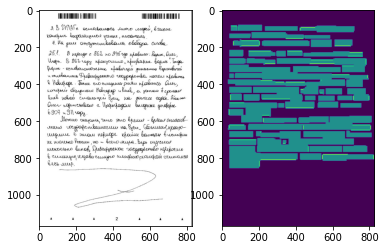

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(Image.open(images[0]).convert('RGB'))
ax[1].imshow(Image.open(masks[0]))

In [ ]:
import numpy as np
import cv2 as cv

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
aux_params=dict(
    pooling=args['POOLING'],                 # one of 'avg', 'max'
    dropout=args['DROPOUT'],                 # dropout ratio, default is None
    activation=args['ACTIVATION'],           # activation function, default is None
    classes=args['CLASSES'],                 # define number of output labels
  )

model = Unet(args['DECODER_MODEL'], encoder_weights=None, activation=args['ACTIVATION'], aux_params=aux_params)
#model.load_state_dict(torch.load('model.pt'))
model.load_state_dict(torch.load('model.pt'))
model.to(args['DEVICE']); 

In [ ]:
def prepare_image(image_path, size):
  image = Image.open(image_path).convert('RGB')
  image = image.resize((size[1],size[0]), resample=Image.BILINEAR)
  image = np.array(image)
  #TO GREY!
  image_to_model = albu.Compose([albu.Normalize(), albu.ToGray(1)])(image=image)['image']
  return image, image_to_model


In [ ]:
def make_mask(model, image, device):
  tensor = torch.tensor(image).permute(2,0,1).unsqueeze(0).to(device)
  mask = model(tensor)[0].squeeze().detach().cpu().numpy()
  return mask*255

In [ ]:
def mask2crops(image, mask, threshold=0.5):
  _, binary = cv.threshold(mask, 255*threshold, 255, cv.THRESH_BINARY) 
  contours, hierarchy = cv.findContours(binary, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  croped_images = []
  
  for contour in contours:
    rect = cv.boundingRect(contour)
    if rect[3] <21 or rect[2] < 21:
      continue
    img_croped = image[rect[1]-5:rect[1]+rect[3]+5,rect[0]-5:rect[0]+rect[2]+5]
    if img_croped.shape[1] <1:
      continue
    croped_images.append(img_croped)
  return croped_images

In [ ]:
def image2cropPipline(model, image_path, size, threshold=0.5, device='cpu'):
  '''
    На вход подается путь к картинке, на выход отдается list кропов (np.array) 
    разной длины, нужна постобработка Normalize() паддинги.
  '''
  image, model_image = prepare_image(image_path, size)
  mask = make_mask(model, model_image, device).astype(np.uint8)
  crops = mask2crops(image, mask, threshold)
  return crops[::-1], mask

In [ ]:
crops, mask = image2cropPipline(model, '/content/test.jpg', (args['IMAGE_H'],args['IMAGE_W']), threshold=0.5, device=args['DEVICE'])

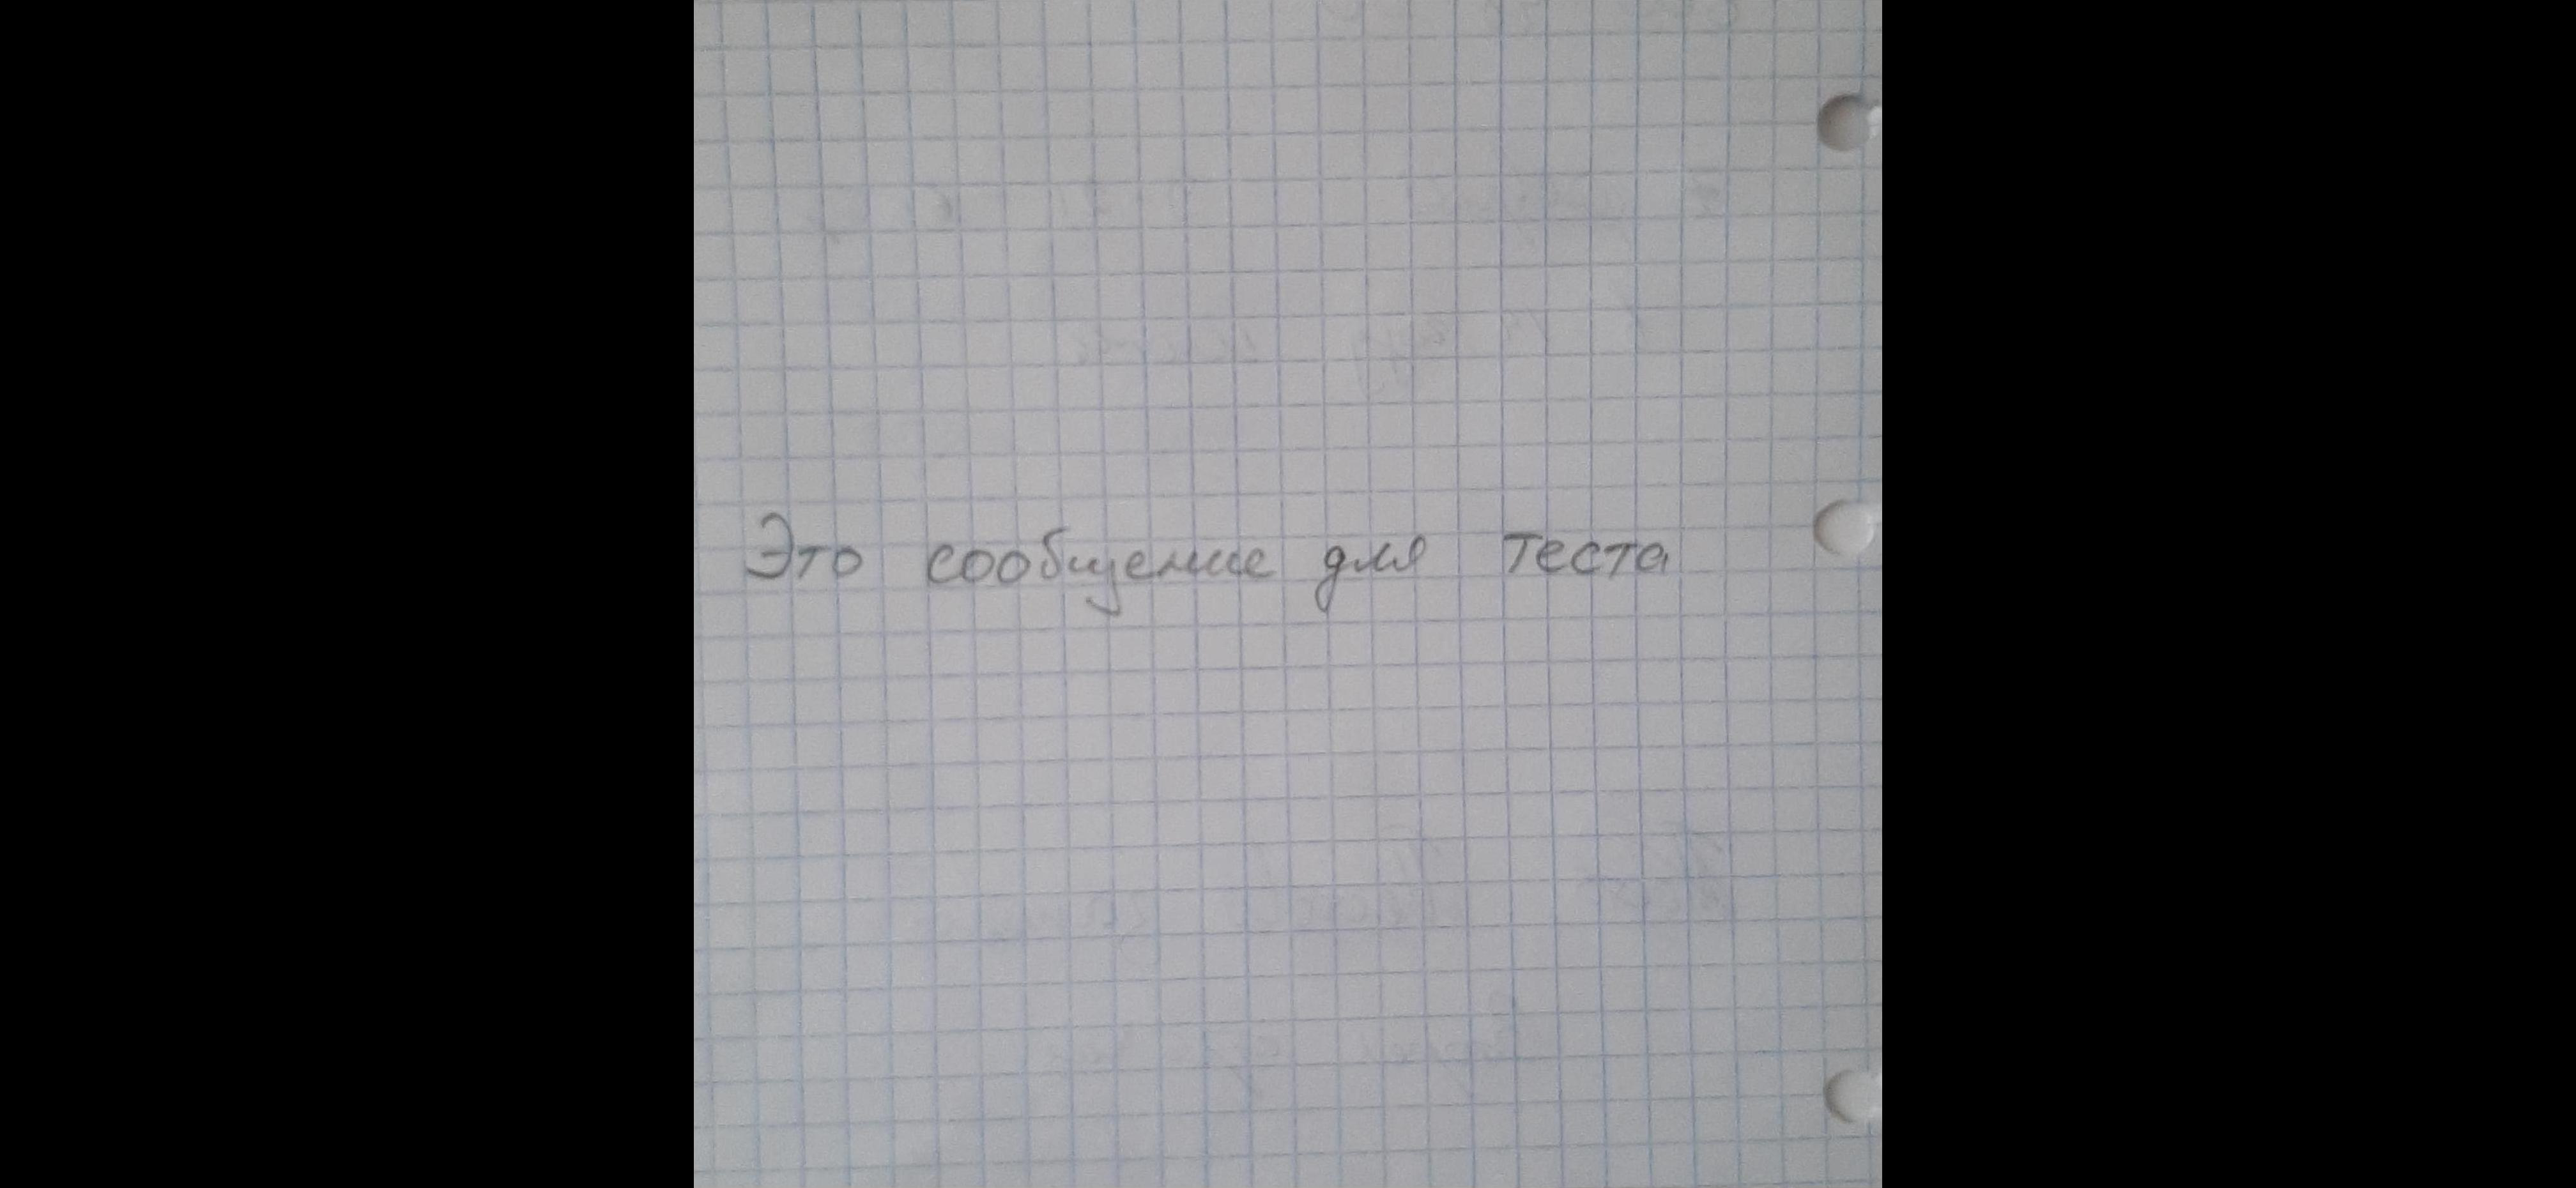

In [ ]:
Image.open('/content/test.jpg')

In [ ]:
for crop in crops:
  print(crop.shape)

(412, 484, 3)


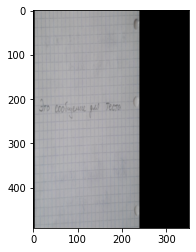

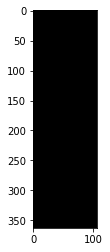

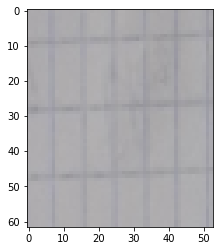

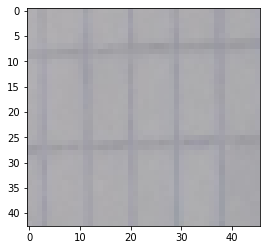

In [ ]:
for crop in crops:
  try:
    plt.imshow(crop)
    plt.show()
  except:
    pass

In [ ]:
crops, mask = image2cropPipline(model, '/content/test2.jpg', (args['IMAGE_H'],args['IMAGE_W']), threshold=0.5, device=args['DEVICE'])

In [ ]:
for crop in crops:
  print(crop.shape)

(50, 73, 3)
(38, 52, 3)
(33, 53, 3)
(43, 88, 3)
(92, 151, 3)
(91, 215, 3)
(47, 90, 3)
(32, 46, 3)
(175, 261, 3)
(56, 111, 3)
(177, 242, 3)
(117, 119, 3)
(32, 31, 3)


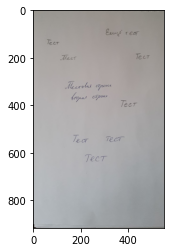

In [ ]:
plt.imshow(Image.open('/content/test2.jpg'))

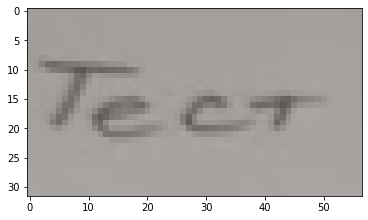

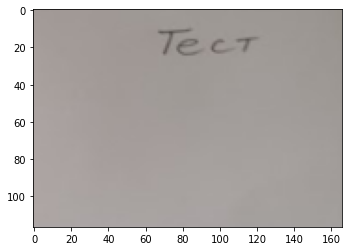

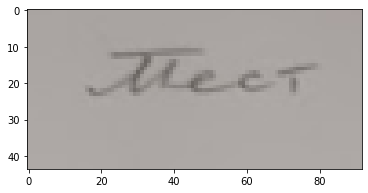

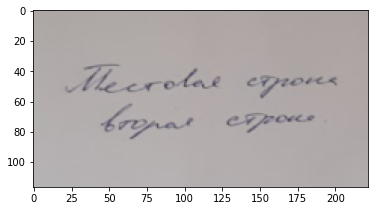

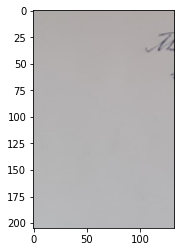

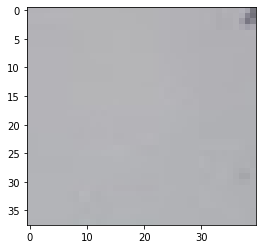

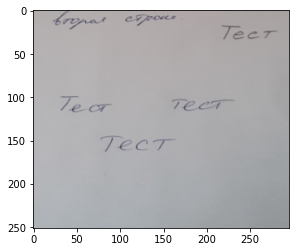

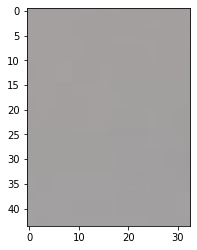

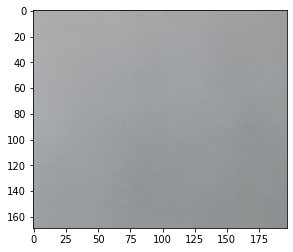

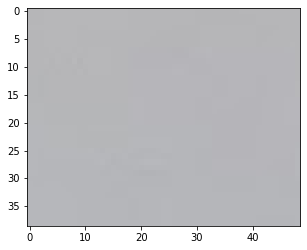

In [ ]:
for crop in crops:
  try:
    plt.imshow(crop)
    plt.show()
  except:
    pass

In [ ]:
crops, mask = image2cropPipline(model, '/content/test3.jpg', (args['IMAGE_H'],args['IMAGE_W']), threshold=0.5, device=args['DEVICE'])

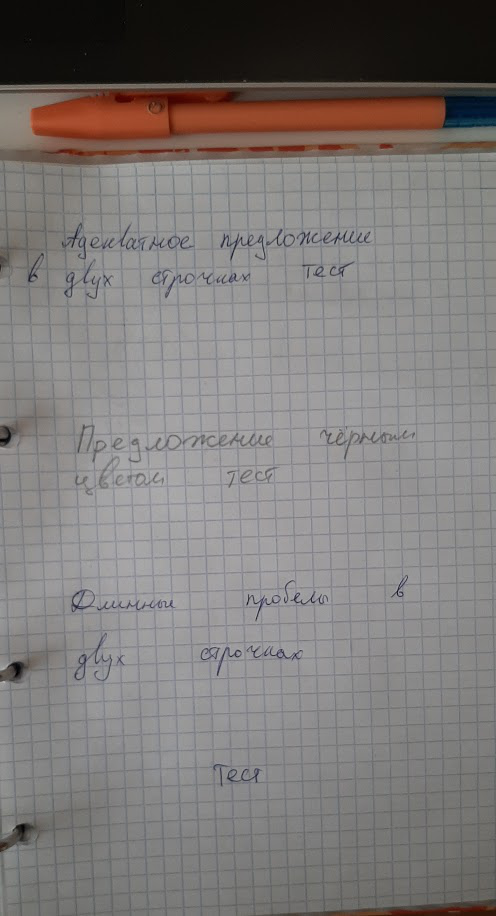

In [ ]:
Image.open('/content/test3.jpg')

In [ ]:
for crop in crops:
  print(crop.shape)

(74, 155, 3)
(37, 159, 3)
(209, 310, 3)
(48, 135, 3)
(53, 39, 3)
(38, 75, 3)
(35, 37, 3)


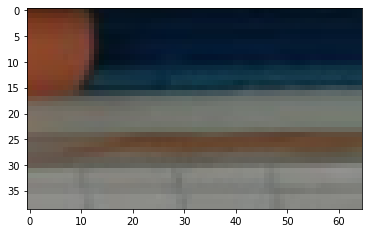

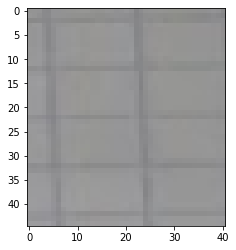

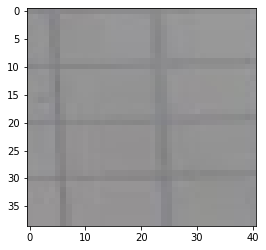

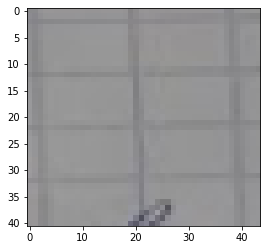

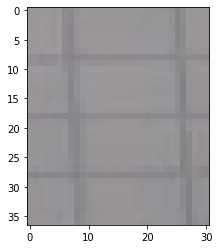

In [ ]:
for crop in crops:
  try:
    plt.imshow(crop)
    plt.show()
  except:
    pass

In [ ]:
# ЕЩЁ НЕ РАБОТАЕТ)
def postprocessing(crops, thresh):
  new_crops = []
  for crop in crops:
    try:
      gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    except:
      continue
    ret, thresh = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
    kernel = np.ones((1,20), np.uint8)
    img_dilation = cv2.dilate(thresh, kernel, iterations=1)
    ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    #print(len(sorted_ctrs))
    for i, ctr in enumerate(sorted_ctrs):
      x, y, w, h = cv2.boundingRect(ctr)
      if w < 9 or h < 9:
        print(w, h)
        continue
      roi = crop[y:y+h, x:x+w]
      #cv2_imshow(roi)
      #img_croped = crop[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
      new_crops.append(roi)
      #cv2_imshow(roi)
      #new_crops.append(img_croped)
  return new_crops
